# Preprocessing

Данный ноутбук направлен на предобработку сырых данных и подготовки их к этапу моделинга.

Импортируем библиотеки и прописываем пути, устанавливаем random_state.

In [1]:
import pandas as pd
import numpy as np
import warnings
import scipy
import re

import matplotlib.pyplot as plt

from tqdm import tqdm
from tqdm import notebook 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
import pickle

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 

In [2]:
tqdm.pandas()
warnings.filterwarnings("ignore")

In [3]:
PATH_COVERS = 'data/raw/covers.json'
PATH_TRANSLETE_LYRICS = 'data/preprocessing/translated_lyrics.csv'
PATH_META = 'data/raw/meta.json'
PATH_TRANSLETE_TITLE = 'data/preprocessing/translated_title.csv'

PATH_SAVE_UNITED_DF = 'data/preprocessing/united_df.csv'

PATH_SAVE_TRAIN_TASK1 = 'data/preprocessing/train_task_1.csv'
PATH_SAVE_TEST_TASK1 = 'data/preprocessing/test_task_1.csv'
PATH_SAVE_TEST_TASK1_TRACK_ID = 'data/preprocessing/test_task_1_track_id.csv'

PATH_SAVE_TRAIN_FAISS = 'data/preprocessing/train_faiss.csv'
PATH_SAVE_TEST_FAISS = 'data/preprocessing/test_faiss.csv'
PATH_SAVE_VALID_FAISS = 'data/preprocessing/valid_faiss.csv'
PATH_SAVE_ALL_FAISS = 'data/preprocessing/all_faiss.csv'

PATH_SAVE_TFIDFVECTORIZER = 'models/task_2_tfidf.pkl'

PATH_SAVE_TRAIN_CORPUS = 'data/preprocessing/train_corpus.npz'
PATH_SAVE_TEST_CORPUS = 'data/preprocessing/test_corpus.npz'
PATH_SAVE_VALID_CORPUS = 'data/preprocessing/valid_corpus.npz'

RANDOM_STATE = 54321

## Создание препроцессинга для объединённого датасета

В данном подразделе проведём предобработку данных и сформируем базовый датасет с которым будем работать дальше

Поскольку нам потребуется работать с текстом и проводить его лемматизацию, то сразу скачаем нужные расширения для nltk

In [4]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yaros\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\yaros\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yaros\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Создадим лемматайзер

In [5]:
lemmatizer = WordNetLemmatizer()

Напишем функции для очистки текста

In [6]:
def clear_text(text: str) -> str:
    new_text = re.sub(r'[^a-zA-Z0-9]', ' ', text)    
    new_text = new_text.split()
    new_text = new_text
    return ' '.join(new_text).lower()

Создадим функцию для лемматизации

In [7]:
def lemmatize(text: str) -> str:
    text_list = nltk.word_tokenize(text)
    lemm_list = []    
    for word in text_list:
        lemm_list.append(lemmatizer.lemmatize(word))    
    lemm_text = " ".join(lemm_list)        
    return lemm_text

Создадим функцию, которая на вход будет принимать датасет, столбец с текстом и проводить лемматизацию в столбец lemm_text. Поскольку операцию может быть достаточно долгой, то будем проводить её по батчам

In [8]:
def lemmatize_df(df: pd.DataFrame, 
                 text_column: str, 
                 batch_size: int = 1000) -> pd.DataFrame:
    df = df.copy(deep=True)
    df = df.reset_index(drop=True)
    column_name = f'lemm_{text_column}'
    df[column_name] = ''
    for i in notebook.tqdm(range(df.shape[0] // batch_size + 1)):
        n = i * batch_size
        df.loc[n:n + batch_size - 1, column_name] = df.loc[n:n + batch_size - 1, text_column].apply(clear_text) 
        df.loc[n:n + batch_size - 1, column_name] = df.loc[n:n + batch_size - 1, column_name].apply(lemmatize) 
    return df[column_name].values

Напишем ряд функций, которые также будем использовать при объединении датасета.

Напишем функцию для обработки текстовых данных, в том числе и для лемматизации

In [9]:
def preproc_text(df: pd.DataFrame) -> pd.DataFrame:  
    # заполним пропуски в translate_text меткой unknown предврительно добавим столбец с меткой
    df['missing_text'] = df['translate_text'].isna().astype('int8')
    df['missing_title'] = df['translate_title'].isna().astype('int8')
    
    df.loc[~df['translate_text'].isna(), 'lemm_text'] = lemmatize_df(df.loc[~df['translate_text'].isna()], 'translate_text')    
    df['lemm_text'] =  df['lemm_text'].fillna('unknown') 
    
    df.loc[~df['translate_title'].isna(), 'lemm_title'] = lemmatize_df(df.loc[~df['translate_title'].isna()], 'translate_title')    
    df['lemm_title'] =  df['lemm_title'].fillna('unknown') 
    # удалим старые столбцы    
    df = df.drop(['translate_title', 'translate_text'], axis = 1)     
    
    # на лемматизации могли полностью уйти некоторые тексты и заголовки, поэтому добавим таким соответствующую метку
    df.loc[df['lemm_text']=='', 'missing_text'] = 1
    df.loc[df['lemm_title']=='', 'missing_title'] = 1
    df.loc[df['lemm_text']=='', 'lemm_text'] = 'non_lemm' 
    df.loc[df['lemm_title']=='', 'lemm_title'] = 'non_lemm'
    
    return df

Создадим функцию, которая восстанавливает язык из первоначальных и полученных данных.

In [10]:
def preproc_language(df: pd.DataFrame) -> pd.DataFrame:  
    # заполним пропуски в языке сначала на основе языка текста, если его нет, то по языку заголовка
    df.loc[df['language'].isna(), 'language'] = df.loc[df['language'].isna(), 'lyric_language']
    df.loc[df['language'].isna(), 'language'] = df.loc[df['language'].isna(), 'title_language']
    df.loc[df['language'].isna(), 'language'] = 'unknown'
    # удалим использованные столбцы с языками    
    df = df.drop(['lyric_language', 'title_language'], axis = 1)    
    return df

Напишем функцию для полуения признаков из isrc

In [11]:
def get_features_isrc(df: pd.DataFrame) -> pd.DataFrame:  
    df = df.copy(deep = True)
    # вытягиваем признаки из isrc делае предварительно стодбец с меткой отсутсвия данного параметра
    df['missing_isrc'] = df['isrc'].isna().astype('int8') 
    df['isrc'] = df['isrc'].str.replace('-', '') # уберём дефисы
    df['isrc'] = df['isrc'].str.replace(' ', '') # предусмотрим возможность убрать пробелы
    # получим год создания записи в виде строки
    df.loc[~df['isrc'].isna(), 'cat_year_isrc'] = (df.loc[~df['isrc'].isna(), 'isrc']
                                                               .str[5:7].apply(lambda x: '19' +  x if int(x) > 23 
                                                                               else '20' + x))
    # преобразуем в числовой признак
    df.loc[~df['cat_year_isrc'].isna(),'num_year'] = df.loc[~df['cat_year_isrc'].isna(), 'cat_year_isrc']
    # для строк с пропусками вытянем год из dttm
    df.loc[df['cat_year_isrc'].isna(),'num_year'] = df.loc[df['cat_year_isrc'].isna(), 'dttm'].dt.year
    df['num_year'] = df['num_year'].astype('int')
    
    # извлекаем код страны
    df['country_of_track'] = df['isrc'].str[:2]
    # извлекаем код регистранта
    df['reg_code'] = df['isrc'].str[2:5]
    df[['cat_year_isrc', 'country_of_track', 'reg_code']] = df[['cat_year_isrc', 
                                                                'country_of_track', 
                                                                'reg_code']].fillna('unknown')
    # удалим столбец isrcc    
    df = df.drop('isrc', axis = 1)   
    
    return df

Напишем функцию для получения жанров

In [12]:
def preproc_genres(df: pd.DataFrame) -> pd.DataFrame:  
    df = df.copy(deep = True) 
    # создадим словарь с количеством вхождений жанров, отсортируем его и возьмём топ 15 популярных жанров
    dict_genres = dict()
    for genres in df['genres'].values:
        for genre in genres:
            if genre not in dict_genres.keys():
                dict_genres[genre] = 0
            dict_genres[genre] += 1
    dict_genres = sorted(dict_genres.items(), key=lambda item: item[1], reverse=True)
    top_15_genres = [x[0] for x in dict_genres [:15]]

    # закодируем их
    for genre in top_15_genres:
        df[f'genre_{genre}'] = df['genres'].apply(lambda x: 1 if genre in x else 0)

    # обработаем треки без жанра   
    mask = df['genres'].isin([[]])
    df['unknown_genre'] = mask.astype('int8')

    # обработаем невошедшие треки
    df['genre_other'] = 0
    df.loc[~mask, 'genre_other'] = (df.loc[~mask, 'genres']
                                          .apply(lambda x: max([1 if i not in top_15_genres else 0 for i in x])))

    # сделаем группировку по крпуным жанрам
    for group_genre in ['ROCK', 'RAP', 'POP', 'FOLK', 'RUS']:
        column = f'genre_group_{group_genre}'
        df[column] = 0
        df.loc[~mask, column] = (df.loc[~mask, 'genres']
                                          .apply(lambda x: max([1 if group_genre in i else 0 for i in x])))
    df = df.drop('genres', axis = 1)
    return df

Напишем функцию, которая на вход будет принимать пути к нашим датасетам, проводить чистку данных и возвращать объединённый датасет. 

In [13]:
def get_united_df(path_covers: str, path_lyrics: str, path_title: str, path_meta: str) -> pd.DataFrame:
    df_covers = pd.read_json(path_covers, lines=True)
    df_lyrics = pd.read_csv(path_lyrics)[['track_id', 'language', 'translate_text']]
    df_meta = pd.read_json(path_meta, lines=True, convert_dates=['dttm'])
    df_title = pd.read_csv(PATH_TRANSLETE_TITLE)[['track_id', 'title_language', 'translate_title']]
        
    # удалим дубликаты треков в df_lyric (по track_id)
    df_lyrics = df_lyrics.rename(columns={'language': 'lyric_language'})
    df_lyrics = df_lyrics.drop_duplicates(subset='track_id')
    
    # из df_meta удалим строку с пропуском и убираем треки с 0 длительностью
    df_meta = df_meta.dropna(subset='track_id')
    df_meta = df_meta.drop('title', axis = 1)
    df_meta = df_meta[df_meta['duration']!=0]
    
    # объединяем через left, чтобы не потерять данные
    df_union = (df_meta.merge(df_covers, on = 'track_id', how = 'left')
                     .merge(df_lyrics, on = 'track_id', how = 'left')
                     .merge(df_title, on = 'track_id', how = 'left'))
    
    df_union = preproc_text(df_union)    
    df_union = preproc_language(df_union)
    df_union = get_features_isrc(df_union)
    df_union = preproc_genres(df_union)
    
    return df_union

In [14]:
df_union = get_united_df(PATH_COVERS, PATH_TRANSLETE_LYRICS, PATH_TRANSLETE_TITLE, PATH_META)
df_union.shape

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

(71399, 37)

Выведем первые 5 строк датасета и информацию по нему

In [15]:
df_union.head()

,track_id,dttm,language,duration,original_track_id,track_remake_type,missing_text,missing_title,lemm_text,lemm_title,...,genre_SPIRITUAL,genre_RUSPOP,genre_JAZZ,unknown_genre,genre_other,genre_group_ROCK,genre_group_RAP,genre_group_POP,genre_group_FOLK,genre_group_RUS
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,EN,161120.0,None,COVER,0,0,no more champagne and the firework are through...,happy new year,...,0,0,0,0,0,0,0,0,0,0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,EN,362260.0,None,COVER,0,0,ooh ooh ooh ooh every time you come around you...,bad habit,...,0,0,0,0,0,0,0,0,0,0
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,ES,260000.0,None,COVER,1,0,unknown,for this crazy vanity,...,0,0,0,0,0,0,0,0,1,0
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,ES,190000.0,None,COVER,1,0,unknown,a thousand tear,...,0,0,0,0,0,0,0,0,1,0
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,ES,203000.0,None,COVER,1,0,unknown,sex smoke and alcohol,...,0,0,0,0,0,0,0,0,1,0


In [16]:
df_union.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71399 entries, 0 to 71398
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   track_id              71399 non-null  object        
 1   dttm                  71399 non-null  datetime64[ns]
 2   language              71399 non-null  object        
 3   duration              71399 non-null  float64       
 4   original_track_id     4820 non-null   object        
 5   track_remake_type     71228 non-null  object        
 6   missing_text          71399 non-null  int8          
 7   missing_title         71399 non-null  int8          
 8   lemm_text             71399 non-null  object        
 9   lemm_title            71399 non-null  object        
 10  missing_isrc          71399 non-null  int8          
 11  cat_year_isrc         71399 non-null  object        
 12  num_year              71399 non-null  int32         
 13  country_of_track

У нас формирован первичный датасет для дальнейших задач, в нём есть пропуски, но одни из них не критичны для решения 1 задачи, другие для второй. Поэтому дальнейшую обработку будем вести отдельно для каждой задачи. 

Сохраним получившийся датасет.

In [17]:
df_union.to_csv(PATH_SAVE_UNITED_DF, index=False)

## Обработка датасета для задачи классификации треков по признаку кавер-оригинал (1 задача)

Для решения данной задачи нам потребуется видоизменить датасет: Удалить столбцы с id, датой добавления в базу, текстом, преобразовать track_remake_type. Также попробуем вытащить допонительные признаки из названия трека.

Удалим лишние столбцы

In [18]:
df_task_1 = df_union.drop(['track_id', 'dttm', 'original_track_id', 'lemm_text'], axis=1)

В некоторых треках могут встречаться слова указывающие на принадлежность к каверам (remix, cover) 

In [19]:
df_task_1['cover_word'] = ((df_task_1['lemm_title'].str.count('remix') > 0) |
                          (df_task_1['lemm_title'].str.count('cover') > 0)).astype('int8')
df_task_1 = df_task_1.drop('lemm_title', axis=1)

На этапе EDA было установлено, что треки длиной меньше 89000 и больше 565000, как правило относятся к каверам. Поэтому добавим признак, который будет явно это указывать.

In [20]:
df_task_1['duration_flag'] = ((df_task_1['duration'] < 89000) |
                              (df_task_1['duration'] > 565000)).astype('int8')

Поскольку у нас в целевом признаке стоят пропуски, то удалим такие строки

In [21]:
df_task_1 = df_task_1.dropna(subset='track_remake_type')

Добавим столбец target. Примем его равным 1, если в track_remake_type стоит ORIGINAL

In [22]:
df_task_1['target'] = (df_task_1['track_remake_type'] == 'ORIGINAL').astype('int8')
df_task_1 = df_task_1.drop('track_remake_type', axis=1)

Разделим датсет на обучающую и тестовую выборки

In [23]:
df_task_1_train, df_task_1_test = train_test_split(df_task_1,
                                                   random_state=RANDOM_STATE,
                                                   test_size=0.2,
                                                   stratify=df_task_1['target'])

Сохраним полученные датасеты

In [24]:
df_task_1_train.to_csv(PATH_SAVE_TRAIN_TASK1, index=False)
df_task_1_test.to_csv(PATH_SAVE_TEST_TASK1, index=False)

Выберем track_id для тестового датасета. Они нам понадобятся при оценке работы алгоритма для 3 модели и сохраним его.

In [25]:
df_task_1_test_track_id = df_union.loc[df_task_1_test.index][['track_id']]

In [26]:
df_task_1_test_track_id.to_csv(PATH_SAVE_TEST_TASK1_TRACK_ID, index=False)

## Обработка датасета для задачи нахождения групп каверов / оригиналов (2 задача)

Данный подраздел будет посвящён созданию датасета для решения второй задачи, а также векторизации текста для данной задачи. Чтобы решить эту задачу необходимо наличие столбца original_track_id, чтобы понять какие треки являются каверами, для каких треков. А также наличие текста как такового.

In [27]:
df_task_2 = df_union.dropna(subset='original_track_id')
df_task_2 = df_task_2[df_task_2['missing_text'] == 0]

Для решения данной задачи нам не нужна дата заливки в базу и track_remake_type. Первый столбец удалим, а второй оставим, поскольку он нам может помочь оценивать модель и сами данные.

In [28]:
df_task_2 = df_task_2.drop('dttm', axis = 1)

выведем информацию о датасете и первые 5 строк

In [29]:
df_task_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3032 entries, 114 to 71398
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_id              3032 non-null   object 
 1   language              3032 non-null   object 
 2   duration              3032 non-null   float64
 3   original_track_id     3032 non-null   object 
 4   track_remake_type     3032 non-null   object 
 5   missing_text          3032 non-null   int8   
 6   missing_title         3032 non-null   int8   
 7   lemm_text             3032 non-null   object 
 8   lemm_title            3032 non-null   object 
 9   missing_isrc          3032 non-null   int8   
 10  cat_year_isrc         3032 non-null   object 
 11  num_year              3032 non-null   int32  
 12  country_of_track      3032 non-null   object 
 13  reg_code              3032 non-null   object 
 14  genre_FOLK            3032 non-null   int64  
 15  genre_LATINFOLK       3

In [30]:
df_task_2.head()

,track_id,language,duration,original_track_id,track_remake_type,missing_text,missing_title,lemm_text,lemm_title,missing_isrc,...,genre_SPIRITUAL,genre_RUSPOP,genre_JAZZ,unknown_genre,genre_other,genre_group_ROCK,genre_group_RAP,genre_group_POP,genre_group_FOLK,genre_group_RUS
114,b3f815190f0b9f5dccd5ab1240bc6984,RU,134040.0,b3f815190f0b9f5dccd5ab1240bc6984,ORIGINAL,0,0,and in summer cross on white white snow and we...,in summer cross,0,...,0,1,0,0,0,0,0,1,0,1
150,672374243edf80a61cbade5433ee4f3d,EN,114350.0,672374243edf80a61cbade5433ee4f3d,ORIGINAL,0,0,start your day right have your caf latte with ...,ocean avenue,0,...,0,0,0,0,0,0,0,0,0,0
151,f21c0bc4ef5a4173e243dd130eb022e4,EN,114390.0,f21c0bc4ef5a4173e243dd130eb022e4,ORIGINAL,0,0,everything you do make me come alive make me c...,never say goodbye,0,...,0,0,0,0,0,0,0,0,0,0
152,5178dac1aa69d6ab29975a02f73ec870,EN,100570.0,5178dac1aa69d6ab29975a02f73ec870,ORIGINAL,0,0,when i m with you i m feeling like the sky s m...,malibu,0,...,0,0,0,0,0,0,0,0,0,0
159,c65204658f95b49542cdf18f82925432,RU,145010.0,c65204658f95b49542cdf18f82925432,ORIGINAL,0,0,i m so high on love catch catch i get so high ...,i m getting high,0,...,0,1,0,0,0,0,0,1,0,1


У нас нет пропусков, однако индексы идут в разнобой, поэтому сбросим их

In [31]:
df_task_2 = df_task_2.reset_index(drop=True)

Теперь нам нужно создать столбец в котором будут указаны все каверы / оригиналы для конкретного original_track_id и посчитать их количество

In [32]:
def make_covers_column(df: pd.DataFrame, count_cover=True) -> pd.DataFrame:
    df_new = df.copy(deep=True)
    df_group = df.groupby('original_track_id', as_index= False ).agg({'track_id': ' '. join})
    df_group = df_group.rename(columns = {'track_id': 'cover_list'})
    df_group['cover_list'] = df_group['cover_list'].str.split()
    
    # присоединим список с датасетом и удалим из списка сам трек
    df_new = df_new.merge(df_group, on = 'original_track_id', how='inner')
    df_new['cover_list'] = df_new.apply(lambda x: list(set(x['cover_list']) ^ {x['track_id']}), axis=1)
    
    if count_cover:
        df_new['cover_count'] = df_new['cover_list'].apply(lambda x: len(x))

    #преобразуем в строку, поскольку планируем сохранять датасет в csv
    df_new['cover_list'] = df_new['cover_list'].apply(lambda x: ' '.join(x))
    return df_new

In [33]:
df_task_2 = make_covers_column(df_task_2)
df_task_2.head()

,track_id,language,duration,original_track_id,track_remake_type,missing_text,missing_title,lemm_text,lemm_title,missing_isrc,...,genre_JAZZ,unknown_genre,genre_other,genre_group_ROCK,genre_group_RAP,genre_group_POP,genre_group_FOLK,genre_group_RUS,cover_list,cover_count
0,b3f815190f0b9f5dccd5ab1240bc6984,RU,134040.0,b3f815190f0b9f5dccd5ab1240bc6984,ORIGINAL,0,0,and in summer cross on white white snow and we...,in summer cross,0,...,0,0,0,0,0,1,0,1,,0
1,672374243edf80a61cbade5433ee4f3d,EN,114350.0,672374243edf80a61cbade5433ee4f3d,ORIGINAL,0,0,start your day right have your caf latte with ...,ocean avenue,0,...,0,0,0,0,0,0,0,0,,0
2,f21c0bc4ef5a4173e243dd130eb022e4,EN,114390.0,f21c0bc4ef5a4173e243dd130eb022e4,ORIGINAL,0,0,everything you do make me come alive make me c...,never say goodbye,0,...,0,0,0,0,0,0,0,0,,0
3,5178dac1aa69d6ab29975a02f73ec870,EN,100570.0,5178dac1aa69d6ab29975a02f73ec870,ORIGINAL,0,0,when i m with you i m feeling like the sky s m...,malibu,0,...,0,0,0,0,0,0,0,0,,0
4,c65204658f95b49542cdf18f82925432,RU,145010.0,c65204658f95b49542cdf18f82925432,ORIGINAL,0,0,i m so high on love catch catch i get so high ...,i m getting high,0,...,0,0,0,0,0,1,0,1,,0


Чтобы корректно разделить выборку, добавим столбец для стратификации, для этого выделим группы по количеству каверов у песни. Для этого построим гистограмму

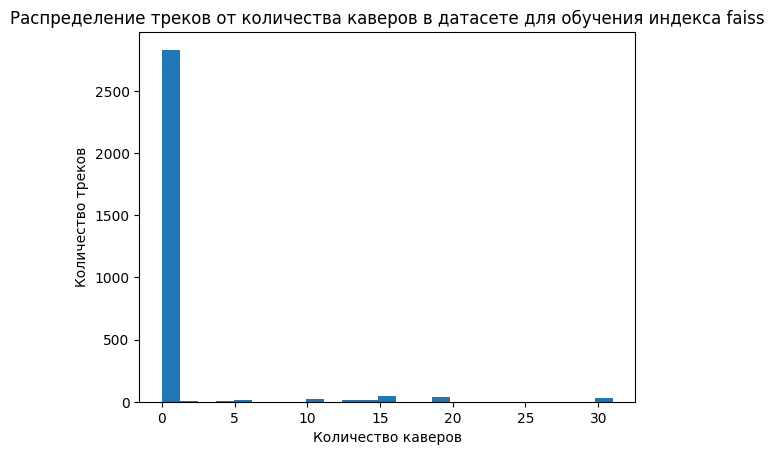

In [34]:
plt.title('Распределение треков от количества каверов в датасете для обучения индекса faiss')
plt.hist(df_task_2['cover_count'], bins=25)
plt.xlabel('Количество каверов')
plt.ylabel('Количество треков')
plt.show()

Выделим следующие группы:
* количество каверов равное 0
* количество каверов от 1 до 10
* количество каверов от 10 до 20
* количество каверов больше 20

In [35]:
df_task_2.loc[df_task_2['cover_count']==0, 'group_count_cover'] = 'group_1'
df_task_2.loc[(df_task_2['cover_count']>0) &
             (df_task_2['cover_count']<=10), 'group_count_cover'] = 'group_2'
df_task_2.loc[(df_task_2['cover_count']>10) &
             (df_task_2['cover_count']<=20), 'group_count_cover'] = 'group_3'
df_task_2.loc[df_task_2['cover_count']>20, 'group_count_cover'] = 'group_4'

Удалим ненужный столбец cover_count

In [36]:
df_task_2 = df_task_2.drop('cover_count', axis=1)

Разделим датасет на тренировочную, тестовую и валидационную выборки.

In [37]:
df_train, df_test = train_test_split(df_task_2,
                                     random_state=RANDOM_STATE,
                                     test_size=0.3,
                                     stratify=df_task_2['group_count_cover'])

In [38]:
df_train.shape, df_test.shape

((2122, 38), (910, 38))

In [39]:
df_test, df_valid = train_test_split(df_test,
                                     random_state=RANDOM_STATE,
                                     test_size=0.5,
                                     stratify=df_test['group_count_cover'])

In [40]:
df_test.shape, df_valid.shape

((455, 38), (455, 38))

Теперь удалим созданные столбцы и пересоздадим их заново (тренировочная выборка не должна ничего знать о тестовой и валидационной, а для тестовой и валидационной выборки нас будут интересовать количество каверов из трейна). 

In [41]:
df_train = df_train.drop(['cover_list', 'group_count_cover'], axis=1)

Для тестовой и валидационной выборки удалим только столбец с группами, и найдём пересечение со списком track_id из трейновой выборки

In [42]:
df_test = df_test.drop(['group_count_cover'], axis=1)
df_valid = df_valid.drop(['group_count_cover'], axis=1)

Получим список каверов для трэйна 

In [43]:
df_train = make_covers_column(df_train, False)

Получим множество track_id в трэйновом датасете

In [44]:
set_train_track = set(df_train['track_id'].values)

Найдём пересечения данного множества со списками значений в cover_list

In [45]:
df_test['cover_list'] = df_test.apply(lambda x: ' '.join(set(x['cover_list'].split()) & set_train_track), axis=1)
df_valid['cover_list'] = df_valid.apply(lambda x: ' '.join(set(x['cover_list'].split()) & set_train_track), axis=1)

Сохраним данные датасеты, они потребуется на обучении модели (поскольку там будем подбирать параметры модели)

In [46]:
df_train.to_csv(PATH_SAVE_TRAIN_FAISS, index=False)
df_test.to_csv(PATH_SAVE_TEST_FAISS, index=False)
df_valid.to_csv(PATH_SAVE_VALID_FAISS, index=False)
df_task_2.to_csv(PATH_SAVE_ALL_FAISS, index=False)

## Создание корпусов текста

Для обработки текста мы планируем воспользоваться TfIdf, на предыдущих этапах мы уже получили лемматизированный текст.

Создадим корпусы для обучения

In [47]:
corpus_train = df_train['lemm_text']
corpus_test = df_test['lemm_text']
corpus_valid = df_valid['lemm_text']

Загрузим стоп слова для английского языка

In [48]:
nltk.download('stopwords')
stopwords = nltk_stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yaros\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Обучим TfIdf и векторизуем наши корпуса. Пока будем передавать только стоп слова, но на этапе моделинга, попробуем подобрать оптимальные параметры для векторизтора

In [49]:
tf_idf = TfidfVectorizer(stop_words=stopwords)

In [50]:
%%time
corpus_train = tf_idf.fit_transform(corpus_train)
corpus_test = tf_idf.transform(corpus_test)
corpus_valid = tf_idf.transform(corpus_valid)

CPU times: total: 359 ms
Wall time: 359 ms


Выведем размеры получившихся корпусов

In [51]:
corpus_train.shape, corpus_test.shape, corpus_valid.shape

((2122, 11868), (455, 11868), (455, 11868))

In [52]:
type(corpus_train)

scipy.sparse._csr.csr_matrix

Сохраним обученный TfidfVectorizer

In [53]:
pickle.dump(tf_idf, open(PATH_SAVE_TFIDFVECTORIZER, "wb"))

Сохраним получившиеся корпуса. Поскольку это разреженные матрицы,  тонапишем функцию, которая будет их сохранять.

In [54]:
def save_sparse_csr(filename: str, array: scipy.sparse):
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

In [55]:
save_sparse_csr(PATH_SAVE_TRAIN_CORPUS, corpus_train)
save_sparse_csr(PATH_SAVE_TEST_CORPUS, corpus_test)
save_sparse_csr(PATH_SAVE_VALID_CORPUS, corpus_valid)

## Выводы

В данном разделе был проведён препроцессинг данных в ходе которого:
1. Создан датасет для задачи классификации кавер / оригинал
    * удалены столбцы с id, датой добавления в базу, текстом;
    * получен признак наличия в названии маркеров кавера (remix, cover);
    * добавлен столбец с отмечающий короткие и длинные треки (там где преимущественно находятся каверы);
    * целевой признак track_remake_type преобразован в target и закодирован по принципу ORIGINAL == 1
2. Сформирован датасет для задачи кластеризации:
    * Использовались в основном сырые данные, кроме датасета с текстами, поскольку они дополнительно отдельно переводились на английский язык. Поскольку данная задача веьма трудозатратная, её выделили в отдельный ноутбук;
    * Данные были очищены, убраны все пропуски, поскольку для обучения модели кластеризации необходимо знать конкретные каверы или оригиналы для треков;
    * Добавлен целевой столбец, содержащий список каверов (оригиналов) для трека;
    * Данные были разделены на тренировочную, тестовую и валидационные выборки для стратификации был создан временный столбец с группировкой по количеству каверов;         
3. Проведена векторизация текстов:
    * Текст был очищен от лишних символов и проведена лемматизация при помощи библиотекии nltk;
    * Обработанные датасеты были сохранены для дальнейшего использования на этапе моделинга;
    * Была проведена векторизация текстов при помощи TfidfVectorizer, на данном этапе в качестве параметров передавались только стоп слова.
    * Обученный TfidfVectorizer и векторизованные корпуса были так же сохранены для дальнейшего использования на этапе моделинга.